

# Sentiment Analysis of covid vaccine Tweets



The data that we are working on is one that we extracted from twitter using a twitter developer account. 
This data contains a bunch of different tweets from all around the World about tha vaccine of COVID19. Our Objectif in This Notebook is to try Classify The Tweets to understand the view of people on it and there thoughts using Sentiment Analysis.

# Importing libraries

In [ ]:
import json
import pandas as pd
import re
import string
from nltk.corpus import stopwords
import json 
import pandas as pd
import re # for regular expressions
pd.set_option("display.max_colwidth", 200)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk # for text manipulation
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import re
import string

from nltk.corpus import stopwords


%matplotlib inline

# Data preprocessing

## Loading the data

In [ ]:
train  = pd.read_csv('train.csv')
test = pd.read_csv('testtweet.csv')
train.shape , test.shape

((31962, 3), (10612, 2))

In [ ]:
test.rename(columns = {'text':'tweet'}, inplace = True)


In [ ]:
combi = train.append(test, ignore_index=True)
combi.shape

(42574, 3)

## Data Cleaning

In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

### Removing Twitter Handles (@user) 

In [ ]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*") 
combi.head()

In [ ]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*") 
combi.head()

In [ ]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "#") 
combi.head()

### Removing Punctuations, Numbers, and Special Characters

In [ ]:
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
combi.head(10)

### Removing Short Words

In [ ]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
combi.head()

id  ...                                                                            tidy_tweet
0   1  ...                    user when father dysfunctional selfish drags kids into dysfunction
1   2  ...  user user thanks lyft credit cause they offer wheelchair vans disapointed getthanked
2   3  ...                                                                   bihday your majesty
3   4  ...                                                             model love take with time
4   5  ...                                                         factsguide society motivation

[5 rows x 4 columns]

### Text Normalization

In [ ]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [ ]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
combi['tidy_tweet'] = tokenized_tweet

# Extracting Features from Cleaned Tweets

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

## Bag-of-Words Features

In [ ]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=5000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(42574, 5000)

## TF-IDF Features

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=5000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(42574, 5000)

# Classification :Model Building

## Support Vector Machine

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import svm
import sklearn.metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

### Bag-of-Words Features

---

---





### data splitting

In [ ]:
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]


# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

### Model Training

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)


0.6164931945556444

### Model Evaluation 

In [ ]:

precision = precision_score(yvalid, prediction_int)
recall = recall_score(yvalid, prediction_int)
accuracy = accuracy_score(yvalid, prediction_int)
f1 = f1_score(yvalid,prediction_int)
print("F1       " + str(f1))
print("Precision" + str(precision))
print("Recall   " + str(recall))
print("Accuracy " + str(accuracy))

F1       0.6164931945556444
Precision0.6814159292035398
Recall   0.5628654970760234
Accuracy 0.9500469287725519


### Test Data Classification

In [ ]:
test_pred = svc.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label','tweet']]
submission.to_csv('BOW5000.csv', index=False)

### TF-IDF Features

In [ ]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

### Training Model

In [ ]:
svctf = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

predictiontf = svctf.predict_proba(xvalid_tfidf)
prediction_inttf = prediction[:,1] >= 0.3
prediction_inttf = prediction_inttf.astype(np.int)
f1_score(yvalid, prediction_inttf)

0.6164931945556444

### Model Evaluation

In [ ]:
precisiontf = precision_score(yvalid, prediction_inttf)
recalltf = recall_score(yvalid, prediction_inttf)
accuracytf = accuracy_score(yvalid, prediction_inttf)
f1tf = f1_score(yvalid,prediction_inttf)
print("F1       " + str(f1))
print("Precision" + str(precision))
print("Recall   " + str(recall))
print("Accuracy " + str(accuracy))

F1       0.6164931945556444
Precision0.6814159292035398
Recall   0.5628654970760234
Accuracy 0.9500469287725519


### Test Data Classification

In [ ]:
test_predtf = svctf.predict_proba(test_bow)
test_pred_inttf = test_pred[:,1] >= 0.3
test_pred_inttf = test_pred_int.astype(np.int)
test['label'] = test_pred_inttf
submission = test[['id','label','tweet']]
submission.to_csv('tfidf5000.csv', index=False) # writing data to a CSV file

# Classified Tweets exploratory analysis 

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
covid=pd.read_csv("tfidf5000.csv")

## Extractiong Positive and Negative Tweets 

In [ ]:
# extracting hashtags from positive tweets

HT_regular = hashtag_extract(covid['tweet'][covid['label'] == 0])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(covid['tweet'][covid['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

## Most Negative HashTag

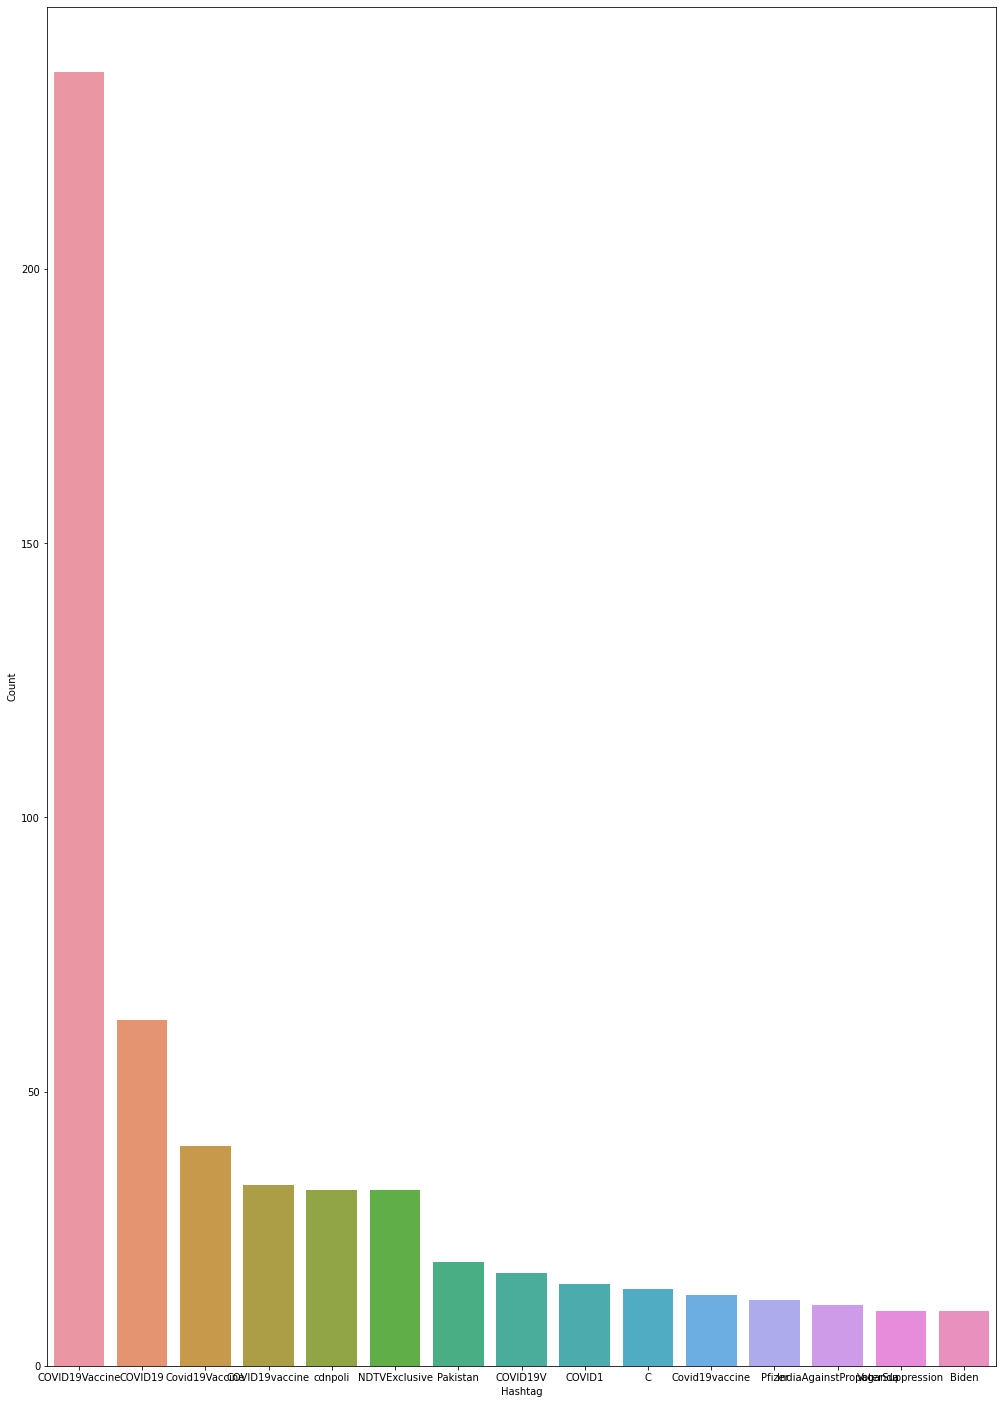

In [ ]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

# selecting top 20 most frequent hashtags
e = e.nlargest(columns="Count", n = 15)   
plt.figure(figsize=(17,25))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")

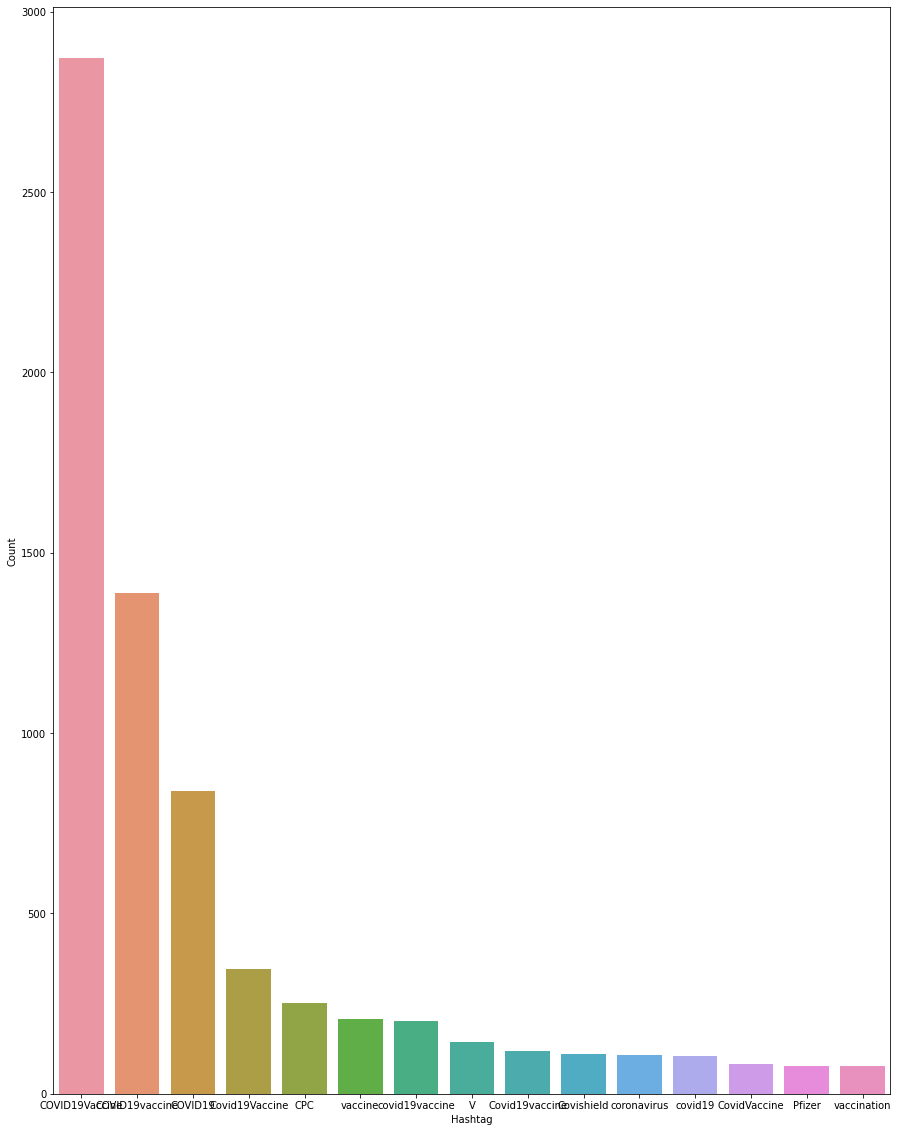

In [ ]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 15) 
plt.figure(figsize=(15,20))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [ ]:
covid['tweets'] = np.vectorize(remove_pattern)(covid['tweet'], "http") 


In [ ]:
covid['tweets'] = covid['tweets'].str.replace("[^a-zA-Z#]", " ")


In [ ]:
covid['tweets'] = covid['tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
tokenized_tweet = covid['tweets'].apply(lambda x: x.split()) # tokenizin

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [ ]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
covid['tweets'] = tokenized_tweet

In [ ]:
wc = WordCloud()

## Negative Word Cloud

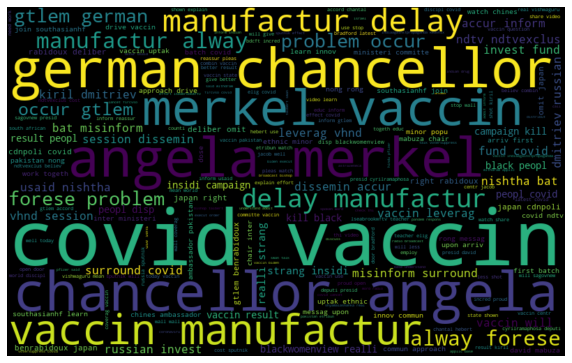

In [ ]:
negative_words = ' '.join([text for text in covid['tweets'][covid['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Positive Word Cloud

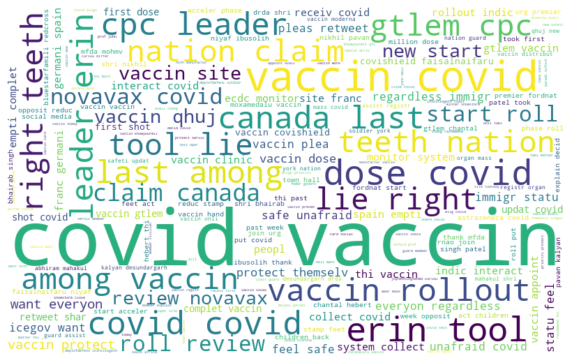

In [ ]:
positive_words =' '.join([text for text in covid['tweets'][covid['label'] == 0]])
wordcloud = WordCloud(width=800, height=500,background_color="white",
random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Pos-Neg tweets distribution

In [ ]:
covid["label"].value_counts()

0    9768
1     844
Name: label, dtype: int64

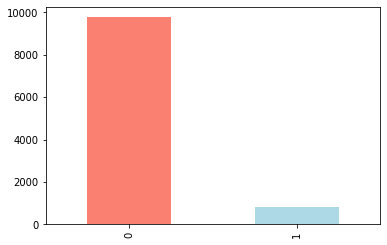

In [ ]:
covid.label.value_counts().plot(kind="bar", color=["salmon", "lightblue"])

In [ ]:
from collections import Counter
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

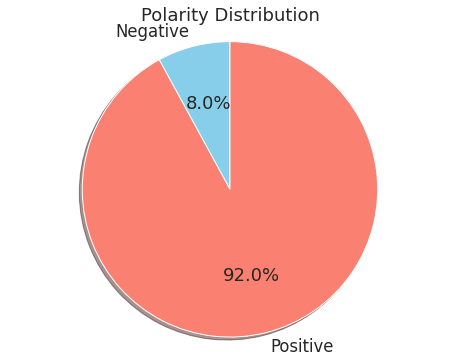

In [ ]:
negative=len(covid[covid['label'] == 1])
positive= len(covid[covid['label']== 0])

plt.figure(figsize=(8,6))

# Data to plot
labels = 'Negative','Positive'
sizes = [negative,positive]
colors = ['skyblue', 'salmon']
explode = (0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Polarity Distribution')
plt.axis('equal')
plt.show()

#Mn Hna t2akdi wach hadchi khasso ykon ola yt7ayd ola blasto ghtbadl 

In [ ]:
class TwitterData_Initialize():
    data = []
    processed_data = []
    wordlist = []

    data_model = None
    data_labels = None
    is_testing = False
    
    def initialize(self, csv_file, is_testing_set=False, from_cached=None):
        if from_cached is not None:
            self.data_model = pd.read_csv(from_cached)
            return

        self.is_testing = is_testing_set

        if not is_testing_set:
            self.data = pd.read_csv(csv_file, header=0, names=["id", "label", "text"])
            self.data = self.data[self.data["label"].isin(["0", "1"])]
        else:
            self.data = pd.read_csv(csv_file, header=0, names=["id", "text"],dtype={"id":"int64","text":"str"},nrows=4000)
            not_null_text = 1 ^ pd.isnull(self.data["text"])
            not_null_id = 1 ^ pd.isnull(self.data["id"])
            self.data = self.data.loc[not_null_id & not_null_text, :]

        self.processed_data = self.data
        self.wordlist = []
        self.data_model = None
        self.data_labels = None

In [ ]:
data = TwitterData_Initialize()
data.initialize("tfidf5000.csv")

In [ ]:
class TwitterCleanuper:
    def iterate(self):
        for cleanup_method in [self.remove_urls,
                               self.remove_usernames,
                               self.remove_na,
                               self.remove_special_chars,
                               self.remove_numbers]:
            yield cleanup_method

    @staticmethod
    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "text"].replace(regexp, "", inplace=True)
        return tweets
          
    def remove_urls(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

    def remove_na(self, tweets):
        return tweets[tweets["text"] != "Not Available"]

    def remove_special_chars(self, tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "text"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"RT@[^\s]+[\s]?"))

    def remove_numbers(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

In [ ]:
class TwitterData_Cleansing(TwitterData_Initialize):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def cleanup(self, cleanuper):
        t = self.processed_data
        for cleanup_method in cleanuper.iterate():
            if not self.is_testing:
                t = cleanup_method(t)
            else:
                if cleanup_method.__name__ != "remove_na":
                    t = cleanup_method(t)

        self.processed_data = t

In [ ]:
from collections import Counter
import nltk
import pandas as pd

import re as regex
import numpy as np
import plotly
from plotly import graph_objs
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
import gensim

# plotly configuration
plotly.offline.init_notebook_mode()

In [ ]:
data = TwitterData_Cleansing(data)
data.cleanup(TwitterCleanuper())
data.processed_data.head(5)

id  ...                                                                                                                                   text
0   0  ...              RT Batting misinformation surrounding COVIDVaccine \nLeveraging VHND sessions to disseminate accurate information on the…
1   1  ...  RT German Chancellor Angela Merkel on Vaccine Manufacturing Delays\n\n“Manufacturers cant always foresee problems that can occur dur…
2   2  ...  RT German Chancellor Angela Merkel on Vaccine Manufacturing Delays\n\n“Manufacturers cant always foresee problems that can occur dur…
3   3  ...                        RT COVID People eventually will accept the CovidVaccine just as they’ve accepted wearing masks It will just be…
4   4  ...                                      RT IGotTheShot Gen Christopher Cavoli commanding general of explains why he decided to get the C…

[5 rows x 3 columns]

In [ ]:
class TwitterData_TokenStem(TwitterData_Cleansing):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def stem(self, stemmer=nltk.PorterStemmer()):
        def stem_and_join(row):
            row["text"] = list(map(lambda str: stemmer.stem(word_tokenize(str.lower())), row["text"]))
            return row

        self.processed_data = self.processed_data.apply(stem_and_join, axis=1)

    def tokenize(self, tokenizer=nltk.word_tokenize):
        def tokenize_row(row):
            row["text"] = tokenizer(row["text"])
            row["tokenized_text"] = [] + row["text"]
            return row

        self.processed_data = self.processed_data.apply(tokenize_row, axis=1)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize


In [ ]:
data = TwitterData_TokenStem(data)
data.tokenize()
data.stem()
data.processed_data.head(5)

TypeError: ignored

In [ ]:
words = Counter()
for idx in data.processed_data.index:
    words.update(data.processed_data.loc[idx, "text"])

words.most_common(5)

[('the', 7372),
 ('RT', 6777),
 ('to', 5027),
 ('of', 4227),
 ('COVIDVaccine', 2902)]

In [ ]:
stopwords=nltk.corpus.stopwords.words("english")
whitelist = ["n't", "not"]
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(20)

[('RT', 6777),
 ('COVIDVaccine', 2902),
 ('COVID', 1983),
 ('vaccine', 1494),
 ('COVIDvaccine', 1393),
 ('amp', 1235),
 ('’', 923),
 ('The', 904),
 ('get', 801),
 ('I', 774),
 ('vaccines', 722),
 ('We', 705),
 ('first', 543),
 ('Vaccine', 489),
 ('CovidVaccine', 457),
 ('vaccination', 437),
 ('“', 427),
 ('doses', 418),
 ('one', 415),
 ('people', 395)]

In [ ]:
class TwitterData_Wordlist(TwitterData_TokenStem):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    whitelist = ["n't","not"]
    wordlist = []
        
    def build_wordlist(self, min_occurrences=3, max_occurences=500, stopwords=nltk.corpus.stopwords.words("english"),
                       whitelist=None):
        self.wordlist = []
        whitelist = self.whitelist if whitelist is None else whitelist
        import os
        if os.path.isfile("wordlist.csv"):
            word_df = pd.read_csv("wordlist.csv")
            word_df = word_df[word_df["occurrences"] > min_occurrences]
            self.wordlist = list(word_df.loc[:, "word"])
            return

        words = Counter()
        for idx in self.processed_data.index:
            words.update(self.processed_data.loc[idx, "text"])

        for idx, stop_word in enumerate(stopwords):
            if stop_word not in whitelist:
                del words[stop_word]

        word_df = pd.DataFrame(data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurences],
                                     "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurences]},
                               columns=["word", "occurrences"])

        word_df.to_csv("wordlist.csv", index_label="idx")
        self.wordlist = [k for k, v in words.most_common() if min_occurrences < v < max_occurences]

In [ ]:
data = TwitterData_Wordlist(data)
data.build_wordlist()

In [ ]:
class TwitterData_BagOfWords(TwitterData_Wordlist):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        self.wordlist = previous.wordlist
    
    def build_data_model(self):
        label_column = []
        if not self.is_testing:
            label_column = ["label"]

        columns = label_column + list(
            map(lambda w: w + "_bow",self.wordlist))
        labels = []
        rows = []
        for idx in self.processed_data.index:
            current_row = []

            if not self.is_testing:
                # add label
                current_label = self.processed_data.loc[idx, "label"]
                labels.append(current_label)
                current_row.append(current_label)
           # add bag-of-words
            tokens = set(self.processed_data.loc[idx, "text"])
            for _, word in enumerate(self.wordlist):
                current_row.append(1 if word in tokens else 0)

            rows.append(current_row)

        self.data_model = pd.DataFrame(rows, columns=columns)
        self.data_labels = pd.Series(labels)
        return self.data_model, self.data_labels

In [ ]:
data = TwitterData_BagOfWords(data)
bow, labels = data.build_data_model()
bow.head(5)

label  Vaccine_bow  ...  Transguard_bow  Ecuador_bow
0      1            0  ...               0            0
1      1            1  ...               0            0
2      1            1  ...               0            0
3      0            0  ...               0            0
4      0            0  ...               0            0

[5 rows x 3930 columns]

In [ ]:
 from plotly import * 

In [ ]:
import plotly.express as px


In [ ]:
positive = covid[covid['label'] != 1]


In [ ]:
positive.to_csv('positive.csv')

In [ ]:
negative.to_csv('negative.csv')

In [ ]:
negative = covid[covid['label'] != 0]

# POSITIVE TWEETS ANALYSIS

In [ ]:
positive=TwitterData_Initialize()
positive.initialize("pos.csv")
positive=TwitterData_Cleansing(positive)
positive.cleanup(TwitterCleanuper())
positive=TwitterData_TokenStem(positive)
positive.tokenize()
positive.stem()

In [ ]:
words = Counter()
for idx in positive.processed_data.index:
    words.update(positive.processed_data.loc[idx, "text"])

words.most_common(5)

[('vaccin', 9585),
 ('covid', 7800),
 ('have', 1292),
 ('thi', 901),
 ('with', 858)]

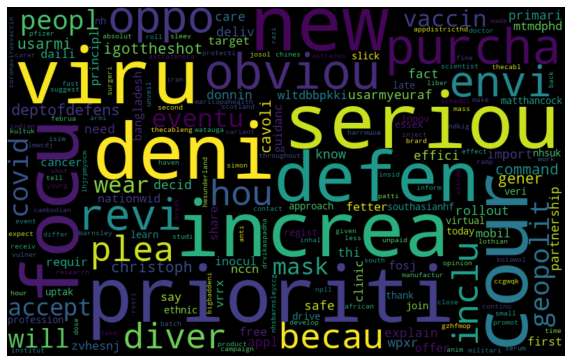

In [ ]:
words = ' '.join([text for text in words])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
hp=TwitterData_Initialize()
hp.initialize("pos.csv")
hp=TwitterData_Cleansing(positive)
hp.cleanup(TwitterCleanuper())
hp=TwitterData_TokenStem(positive)
hp.tokenize()


In [ ]:
words = Counter()
for idx in hp.processed_data.index:
    words.update(hp.processed_data.loc[idx, "text"])

words.most_common(5)

[('vaccin', 9585),
 ('covid', 7800),
 ('have', 1292),
 ('thi', 901),
 ('with', 858)]

In [ ]:
stopwords=nltk.corpus.stopwords.words("english")
whitelist = ["n't", "not"]
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(5)

[('vaccin', 9585),
 ('covid', 7800),
 ('thi', 901),
 ('dose', 782),
 ('gtlem', 685)]

In [ ]:
hp = pd.DataFrame(words.most_common(300),
                             columns=['words', 'count'])
hp.head()

words  count
0  vaccin   9585
1   covid   7800
2     thi    901
3    dose    782
4   gtlem    685

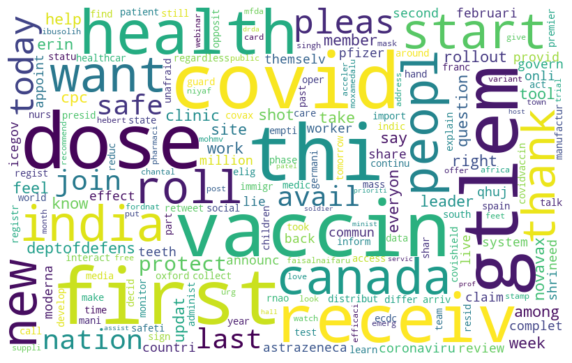

In [ ]:
hui = ' '.join([text for text in hp['words']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21,background_color="white", max_font_size=110).generate(hui)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# NEGATIVE ANALYSIS

In [ ]:
ng=pd.read_csv('negative.csv')

In [ ]:
hp=TwitterData_Initialize()
hp.initialize("ngs.csv")
hp=TwitterData_Cleansing(positive)
hp.cleanup(TwitterCleanuper())
hp=TwitterData_TokenStem(positive)
hp.tokenize()

In [ ]:
words = Counter()
for idx in hp.processed_data.index:
    words.update(hp.processed_data.loc[idx, "text"])

words.most_common(5)

[('vaccin', 9585),
 ('covid', 7800),
 ('have', 1292),
 ('thi', 901),
 ('with', 858)]

In [ ]:
stopwords=nltk.corpus.stopwords.words("english")
whitelist = ["n't", "not"]
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(5)

[('vaccin', 9585),
 ('covid', 7800),
 ('thi', 901),
 ('dose', 782),
 ('gtlem', 685)]

In [ ]:
ngs = pd.DataFrame(words.most_common(30),
                             columns=['words', 'count'])
ngs.head()

words  count
0  vaccin   9585
1   covid   7800
2     thi    901
3    dose    782
4   gtlem    685

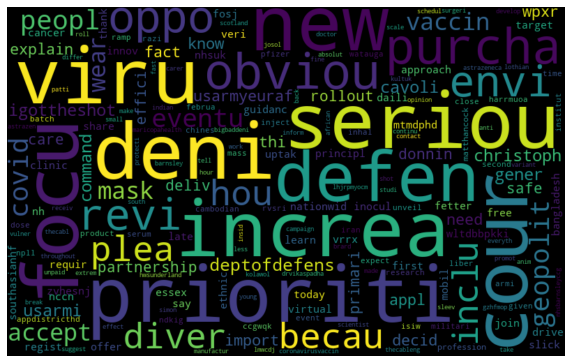

In [ ]:
hui = ' '.join([text for text in words])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(hui)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
nega=pd.read_csv('positive.csv')

In [ ]:
nega['text'] = np.vectorize(remove_pattern)(nega['tweet'], "http")
nega['text'] = nega['text'].str.replace("[^a-zA-Z#]", " ")
nega['text'] = nega['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
tokenized_tweet = nega['text'].apply(lambda x: x.split()) # tokenizin

In [ ]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

In [ ]:
nega['text']= tokenized_tweet

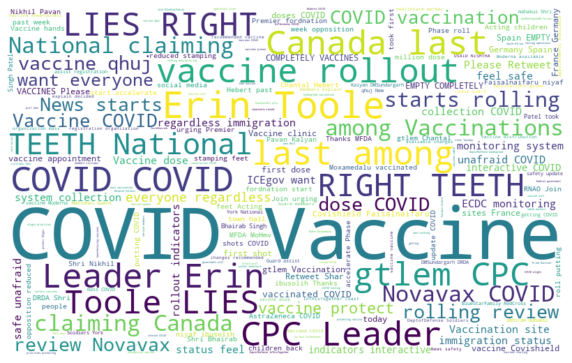

In [ ]:
hui = ' '.join([text for text in nega['text']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, background_color="white" , max_font_size=110).generate(hui)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()